# Chicken Weights by Feed Type

## Dataset

Newly hatched chicks were randomly allocated into six groups, and each group was given a different feed supplement. Their weights in grams after six weeks are given along with feed types.

*Source: Anonymous (1948) Biometrika, 35, 214.*

## Questions to Answer

We want to know: 1) is there a significant difference in weights amongst the various feed types; and, 2) if so, what is the probability that a specific feed type will outperform other feed types.

## Summary

Newly hatched chicks were randomly allocated into six groups, and each group was given a different feed supplement. Their weights in grams after six weeks are given along with feed types.

The response variable is `weight` and the independent variable `feed` is a factor with 6 levels: casein, horsebean, linseed, meatmeal, soybean, and sunflower. There are a total of 71 observations, with 10-14 observations per factor. For this analysis, we'll create a new variable `feed_name` and convert `feed` to a numeric.

Plotting the distributions of weight by feed_name shows some difference across the feed types, with casein and sunflower appearing associated with higher weight.  The sunflower weights appear tightly distributed, with a few outliers. Given the sample size, it's unclear if these are true outliers as the casein group seems to have a similar variance.

## Required Packages

In [2]:
library(tidyverse)
library(rjags)

source("funcs.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs



## Data

Newly hatched chicks were randomly allocated into six groups, and each group was given a different feed supplement. Their weights in grams after six weeks are given along with feed types.

The response variable is `weight` and the independent variable `feed` is a factor with 6 levels: casein, horsebean, linseed, meatmeal, soybean, and sunflower. There are a total of 71 observations, with 10-14 observations per factor. For this analysis, we'll create a new variable `feed_name` and convert `feed` to a numeric.

Plotting the distributions of weight by feed_name shows some difference across the feed types, with casein and sunflower appearing associated with higher weight.  The sunflower weights appear tightly distributed, with a few outliers. Given the sample size, it's unclear if these are true outliers as the casein group seems to have a similar variance.

In [3]:
data = datasets::chickwts %>%
  mutate(
    feed_name = feed,
    feed = as.numeric(feed)
    )

In [4]:
str(data)

'data.frame':	71 obs. of  3 variables:
 $ weight   : num  179 160 136 227 217 168 108 124 143 140 ...
 $ feed     : num  2 2 2 2 2 2 2 2 2 2 ...
 $ feed_name: Factor w/ 6 levels "casein","horsebean",..: 2 2 2 2 2 2 2 2 2 2 ...


In [5]:
head(data)

,weight,feed,feed_name
,<dbl>,<dbl>,<fct>
1,179,2,horsebean
2,160,2,horsebean
3,136,2,horsebean
4,227,2,horsebean
5,217,2,horsebean
6,168,2,horsebean


In [6]:
table(data$feed_name)


   casein horsebean   linseed  meatmeal   soybean sunflower 
       12        10        12        11        14        12 

### Distribution of Weights by Feed Type

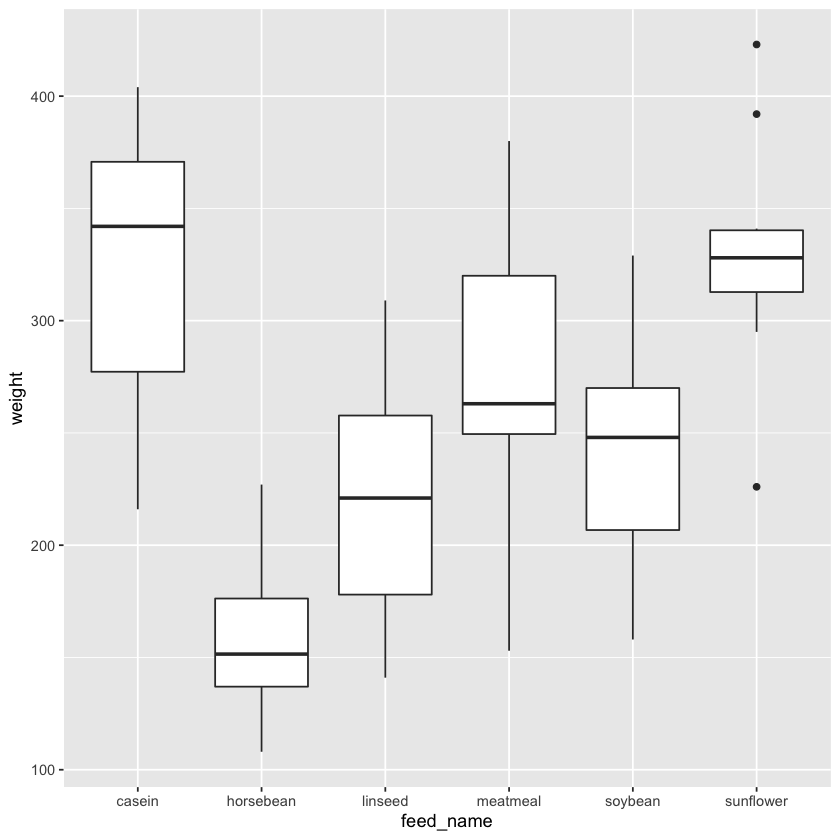

In [7]:
ggplot(data, aes(x=feed_name, y=weight, group=feed_name)) +
  geom_boxplot()

In [8]:
data %>%
    filter(feed_name=="sunflower")

weight,feed,feed_name
<dbl>,<dbl>,<fct>
423,6,sunflower
340,6,sunflower
392,6,sunflower
339,6,sunflower
341,6,sunflower
226,6,sunflower
320,6,sunflower
295,6,sunflower
334,6,sunflower


## Models

### Base Linear Model

We'll user a linear model as a base, and fit without an intercept for easy interpretation and comparison with other methods. Our results mirror the boxplots-- casein and sunflower feeds appear associated with higher weights, but there doesn't seem to be a clear winner amongst the top two. The residuals don't show a clear pattern.

Before analysis, we'll shuffle the dataset so that the observations are not grouped by factor order. 

In [19]:
set.seed(43)
idx = sample(c(1:nrow(data)), nrow(data))
data = data[idx,]

In [20]:
mod.base = lm(weight ~ feed_name + 0, data=data)
summary(mod.base)


Call:
lm(formula = weight ~ feed_name + 0, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-123.909  -34.413    1.571   38.170  103.091 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
feed_namecasein      323.58      15.83  20.436  < 2e-16 ***
feed_namehorsebean   160.20      17.35   9.236 1.91e-13 ***
feed_namelinseed     218.75      15.83  13.815  < 2e-16 ***
feed_namemeatmeal    276.91      16.54  16.744  < 2e-16 ***
feed_namesoybean     246.43      14.66  16.810  < 2e-16 ***
feed_namesunflower   328.92      15.83  20.773  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 54.85 on 65 degrees of freedom
Multiple R-squared:  0.9629,	Adjusted R-squared:  0.9595 
F-statistic: 281.4 on 6 and 65 DF,  p-value: < 2.2e-16


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



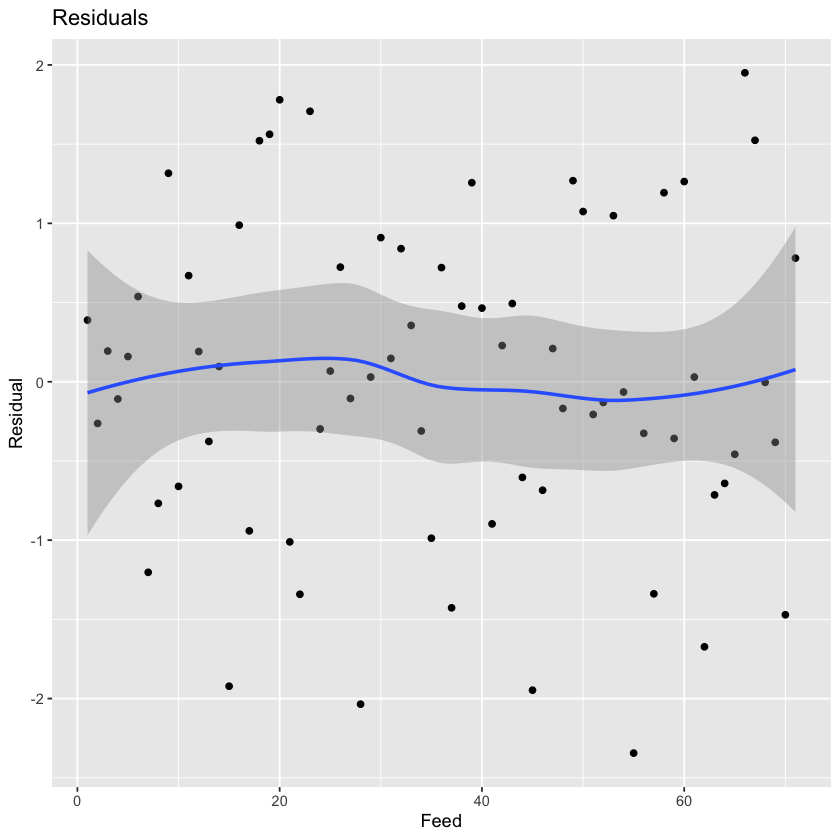

In [21]:
res = data$weight - mod.base$fitted.values
gg_resid(res, normalize=TRUE)

### Pooled Model

$$ Weight_{ij} \sim Normal(\mu, \sigma) $$

In [22]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(mu, prec)
  }
  
  mu ~ dnorm(0, 1/1e6)
  prec ~ dexp(1)
  sigma = sqrt(1/prec)
} "

set.seed(43)
data_jags = as.list(data)
params = c("mu", "sigma")

mod.pooled = run_sim(
  model.str = mod_string,
  data = data_jags,
  params = params
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed" in data”
Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 2
   Total graph size: 79

Initializing model



#### Results

In [23]:
summary(mod.pooled$sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean    SD Naive SE Time-series SE
mu    261.38 9.275  0.07573        0.07574
sigma  77.71 6.646  0.05427        0.05467

2. Quantiles for each variable:

        2.5%    25%    50%    75% 97.5%
mu    243.36 255.19 261.39 267.60 279.6
sigma  66.02  73.06  77.26  81.87  92.2


In [24]:
round(mod.pooled$coefs, 4)

mu    sigma 
261.3765  77.7087

In [25]:
(dic.pooled = dic.samples(mod.pooled$obj, n.iter=1e3))

Mean deviance:  821.2 
penalty 1.987 
Penalized deviance: 823.2 

#### Convergence

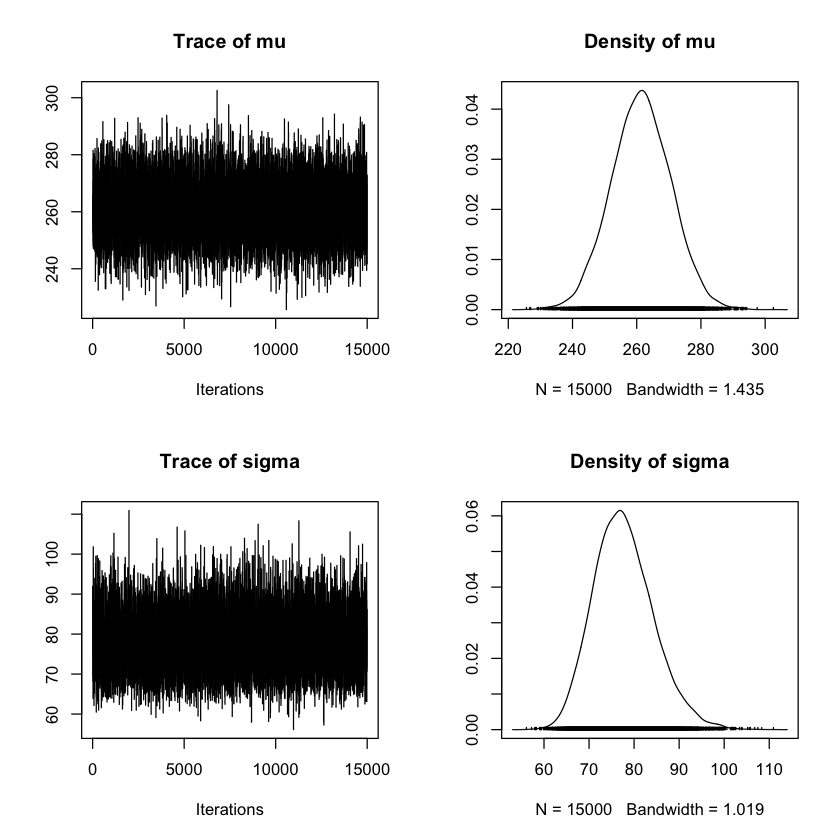

In [26]:
plot(mod.pooled$csim)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



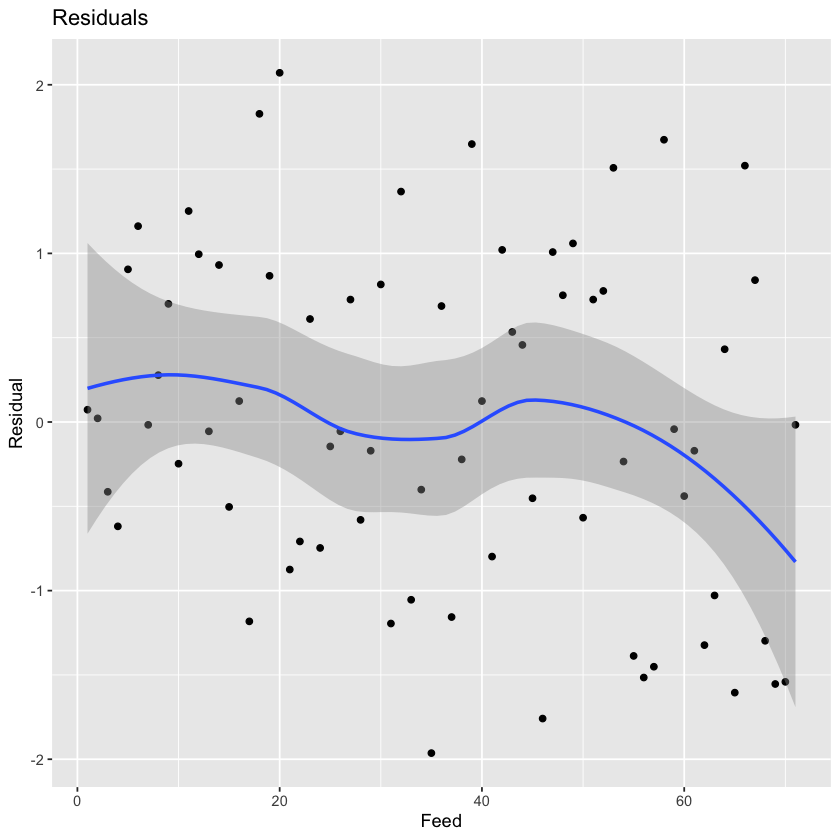

In [27]:
res = data$weight - mod.pooled$coefs[1]
gg_resid(res, normalize=TRUE)

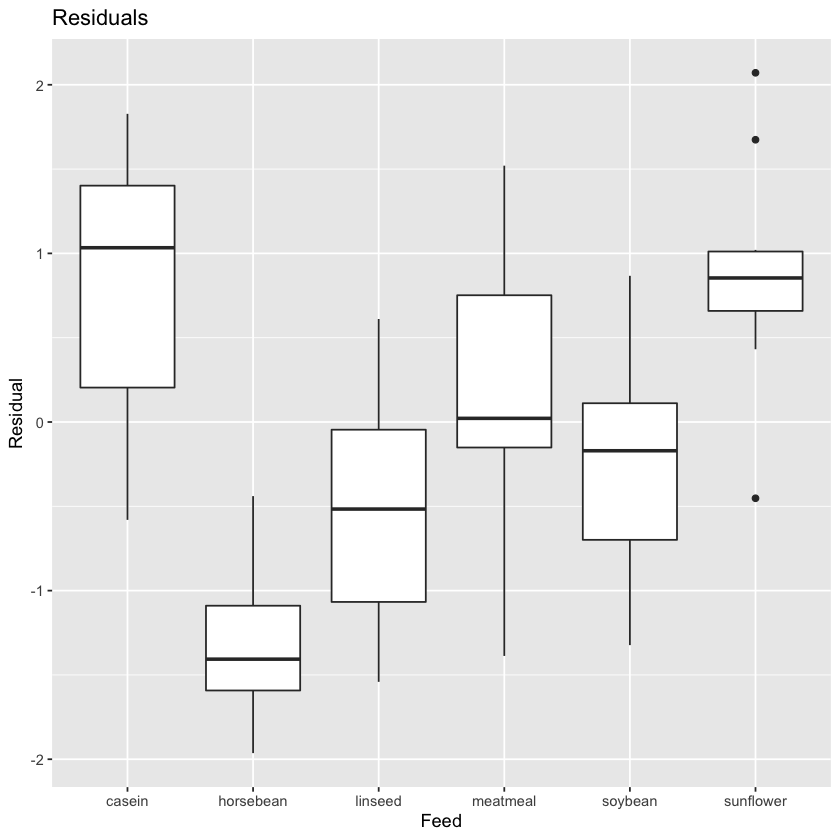

In [28]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

## Hierarchical Model

### Homogenous Variance

$$ Weight_{ij} \sim Normal(\theta_j, \sigma) $$

$$ \theta_j \sim Normal(\mu, \tau) $$

In [29]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(theta[feed[i]], prec.sigma)
  }
  
  for (j in 1:max(feed)) {
    theta[j] ~ dnorm(mu, prec.tau)
  }
  
  mu ~ dnorm(0, 1/1e6)
  prec.tau ~ dexp(1)
  prec.sigma ~ dexp(1)
  tau = sqrt(1/prec.tau)
  sigma = sqrt(1/prec.sigma)
  
} "

set.seed(43)
data_jags = as.list(data)
params = c("theta", "mu", "sigma")

mod.hier = run_sim(
  model.str = mod_string,
  data = data_jags,
  params = params
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 9
   Total graph size: 159

Initializing model



#### Results

In [30]:
summary(mod.hier$sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean     SD Naive SE Time-series SE
mu       258.89 25.412  0.20749        0.22480
sigma     54.84  4.841  0.03953        0.04324
theta[1] 317.50 15.601  0.12738        0.13698
theta[2] 170.38 17.791  0.14526        0.17418
theta[3] 222.39 15.574  0.12716        0.13346
theta[4] 275.23 15.814  0.12912        0.13149
theta[5] 247.36 14.388  0.11748        0.12093
theta[6] 322.51 15.655  0.12782        0.13843

2. Quantiles for each variable:

           2.5%    25%    50%    75%  97.5%
mu       207.64 243.61 258.95 274.39 309.89
sigma     46.34  51.43  54.48  57.84  65.35
theta[1] 286.92 307.00 317.66 327.87 348.15
theta[2] 136.36 158.55 170.11 182.28 205.68
theta[3] 192.06 211.95 222.36 232.82 253.14
theta[4] 244.72 264.52 275.10 285.96 306.26
theta[5] 219.16 237.79 247.31 257.04 2

In [31]:
round(mod.hier$coefs, 4)

mu    sigma theta[1] theta[2] theta[3] theta[4] theta[5] theta[6] 
258.8871  54.8379 317.4984 170.3849 222.3934 275.2269 247.3577 322.5068

In [32]:
(dic.hier = dic.samples(mod.hier$obj, n.iter=1e3))

Mean deviance:  771.6 
penalty 6.857 
Penalized deviance: 778.5 

#### Convergence

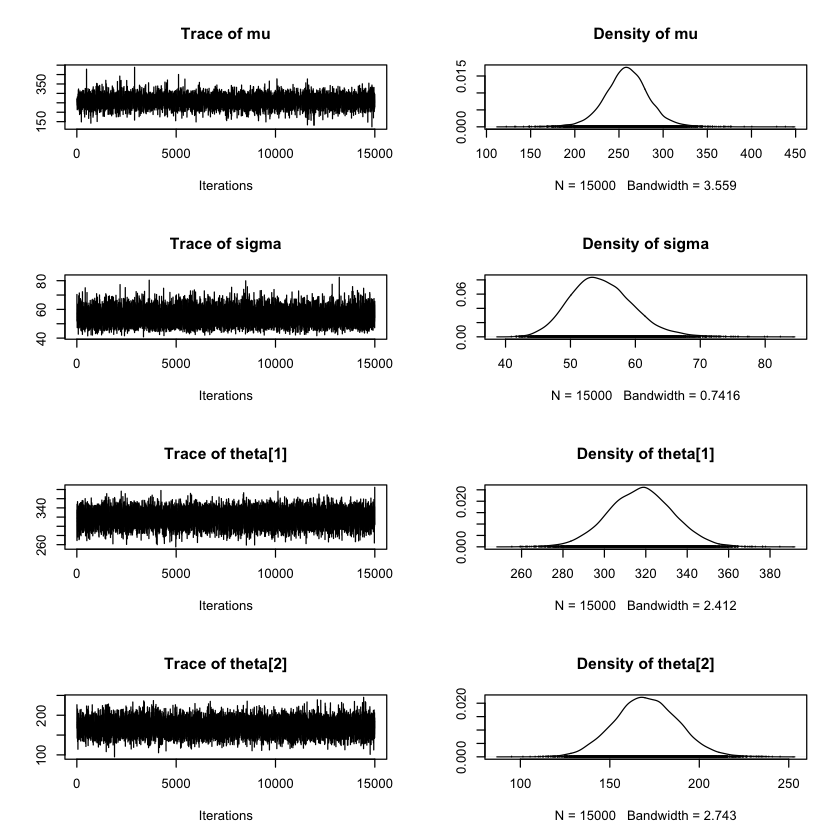

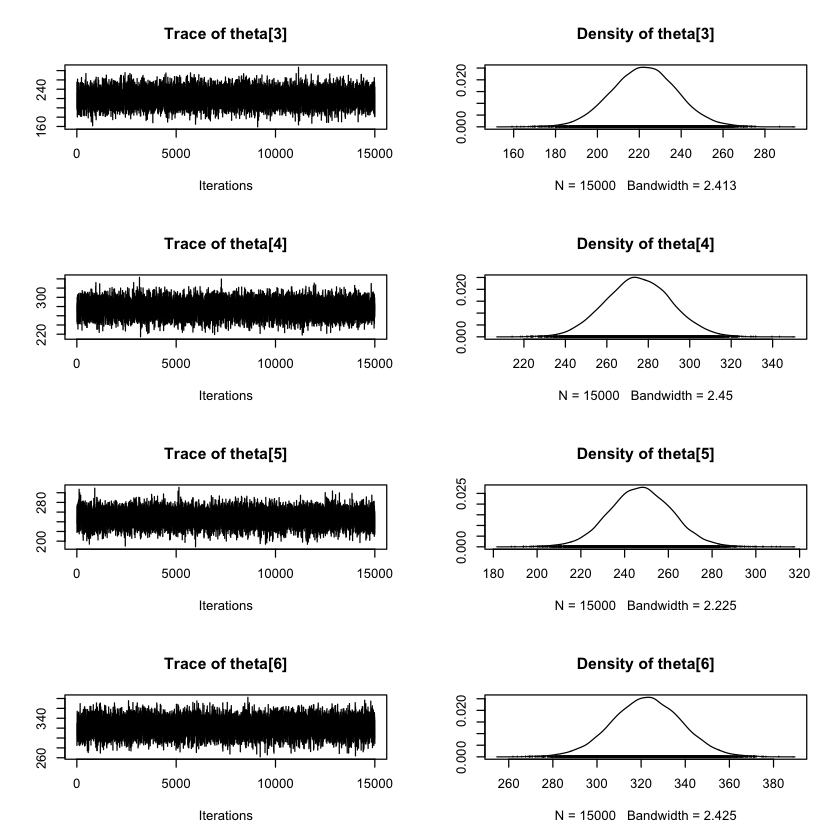

In [49]:
plot(mod.hier$csim, ask=FALSE)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



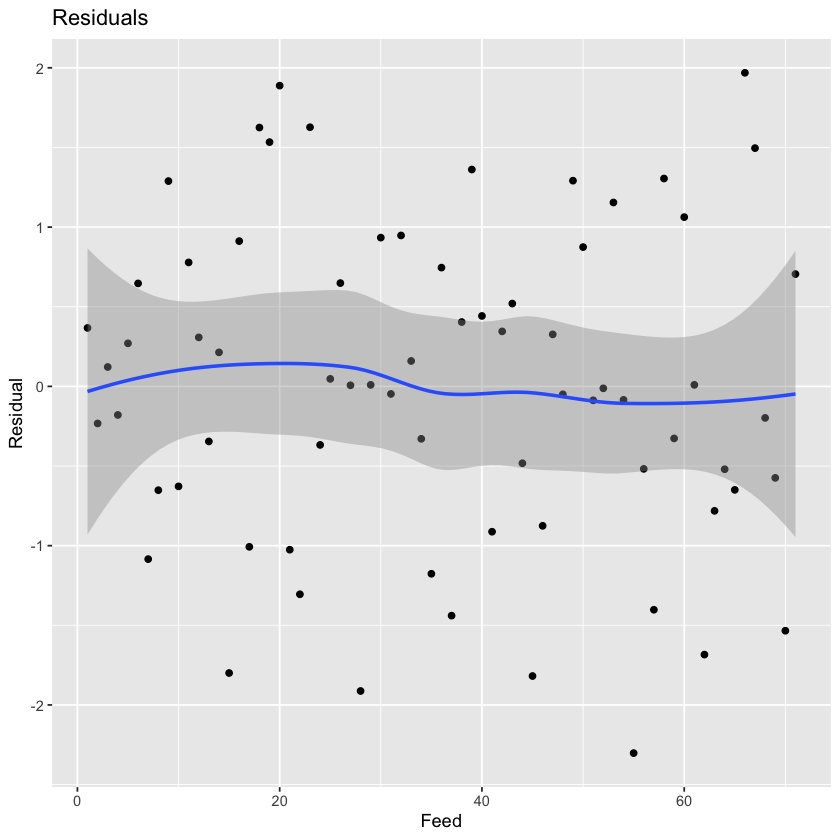

In [47]:
res = data$weight - mod.hier$coefs[3:8][data$feed]
gg_resid(res, normalize=TRUE)

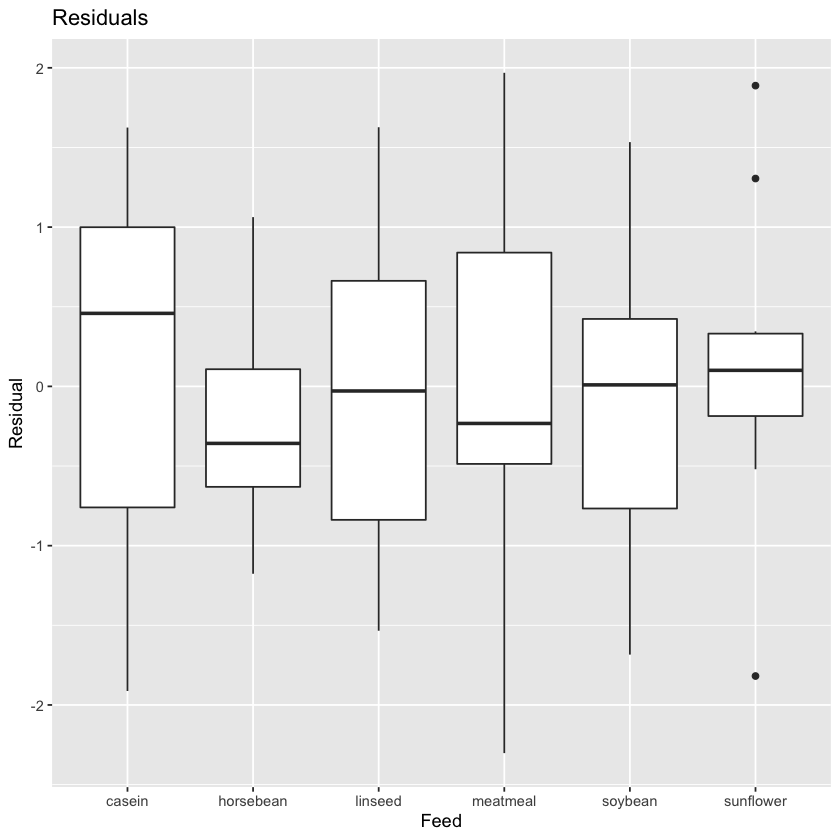

In [48]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

### Heterogenous Variance


$$ Weight_{ij} \sim Normal(\theta_j, \sigma_j) $$

$$ \theta_j \sim Normal(\mu, \tau) $$

$$ \frac{1}{\sigma^2_j} \sim Exp(1) $$

In [50]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(theta[feed[i]], prec.sigma[feed[i]])
  }
  
  for (j in 1:max(feed)) {
    theta[j] ~ dnorm(mu, prec.tau)
    prec.sigma[j] ~ dexp(1)
    sigma[j] = sqrt(1/prec.sigma[j])
  }
  
  mu ~ dnorm(0, 1/1e6)
  prec.tau ~ dexp(1)
  tau = sqrt(1/prec.tau)
  
  
} "

set.seed(43)
data_jags = as.list(data)
params = c("theta", "mu", "sigma")

mod.hier.var.het = run_sim(
  model.str = mod_string,
  data = data_jags,
  params = params
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 14
   Total graph size: 174

Initializing model



#### Results

In [51]:
summary(mod.hier.var.het$sim)


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean    SD Naive SE Time-series SE
mu       258.07 25.96  0.21200        0.22201
sigma[1]  63.07 13.57  0.11077        0.12201
sigma[2]  38.18  9.51  0.07765        0.09088
sigma[3]  51.10 11.04  0.09017        0.09772
sigma[4]  63.06 14.30  0.11675        0.12466
sigma[5]  52.89 10.38  0.08476        0.09249
sigma[6]  47.95 10.34  0.08446        0.09441
theta[1] 316.35 17.99  0.14692        0.16317
theta[2] 165.60 13.01  0.10619        0.12317
theta[3] 221.40 14.73  0.12023        0.12436
theta[4] 274.68 18.30  0.14941        0.15466
theta[5] 247.01 13.89  0.11344        0.11425
theta[6] 324.04 14.11  0.11521        0.12756

2. Quantiles for each variable:

           2.5%    25%    50%    75%  97.5%
mu       205.38 242.51 258.40 273.86 309.48
sigma[1]  43.20  53.52  60.95  70.13 

In [52]:
round(mod.hier.var.het$coefs, 4)

mu sigma[1] sigma[2] sigma[3] sigma[4] sigma[5] sigma[6] theta[1] 
258.0694  63.0679  38.1755  51.1029  63.0624  52.8930  47.9474 316.3469 
theta[2] theta[3] theta[4] theta[5] theta[6] 
165.6013 221.3979 274.6762 247.0059 324.0416

In [53]:
(dic.hier.var.het = dic.samples(mod.hier.var.het$obj, n.iter=1e3))

Mean deviance:  772.3 
penalty 13.06 
Penalized deviance: 785.4 

#### Convergence

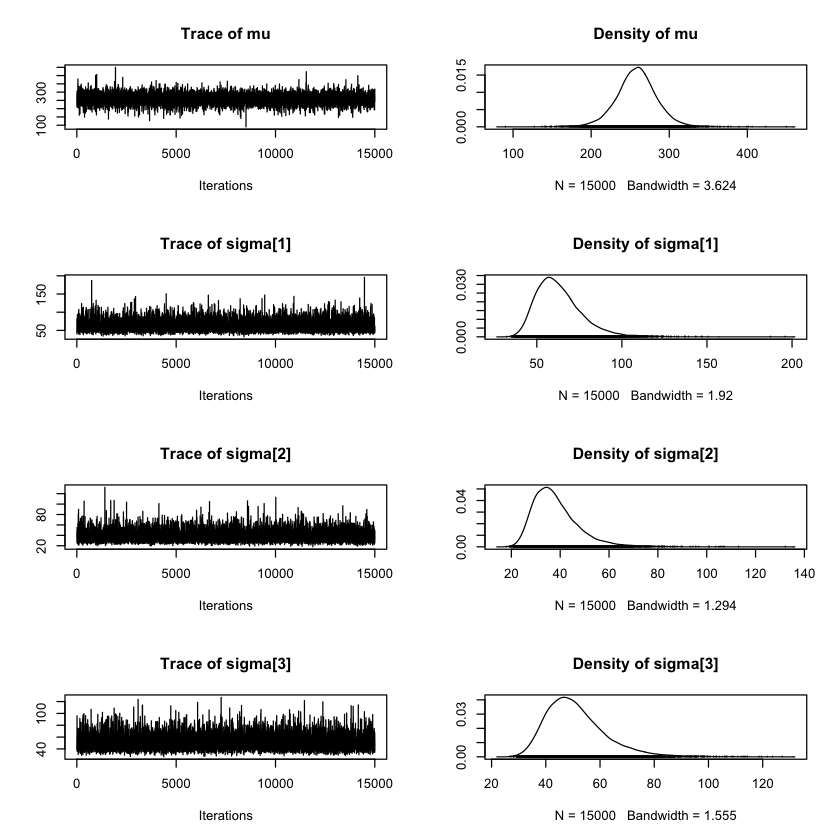

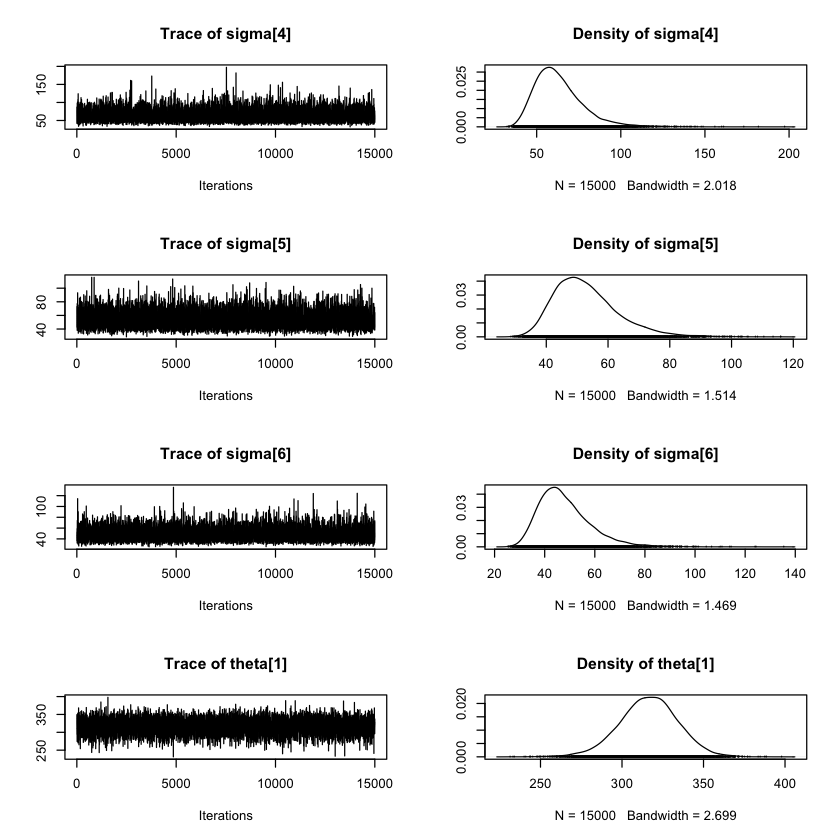

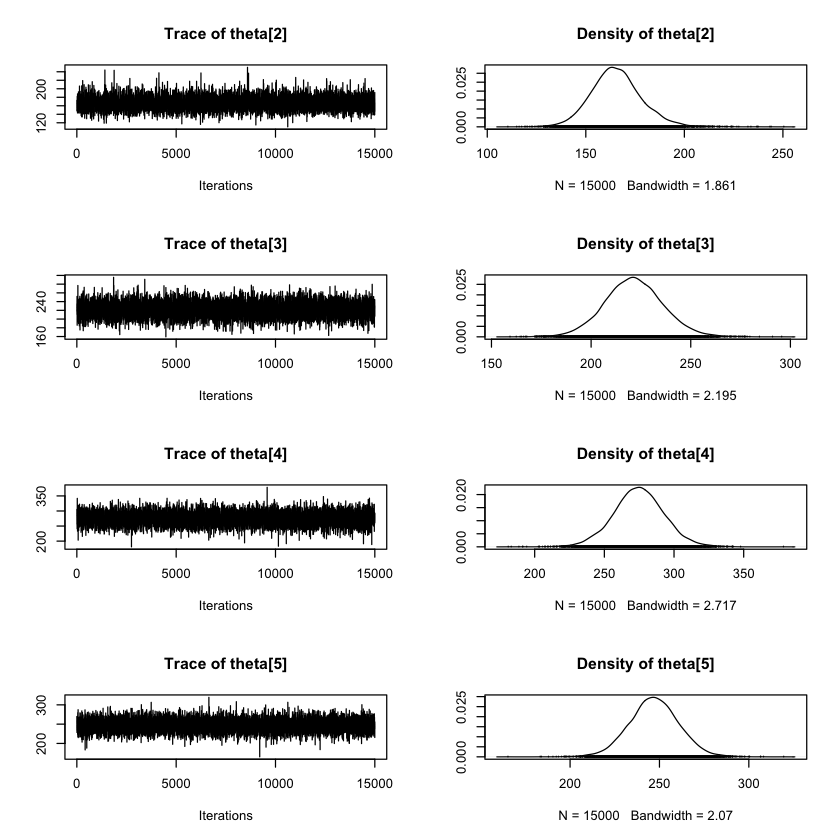

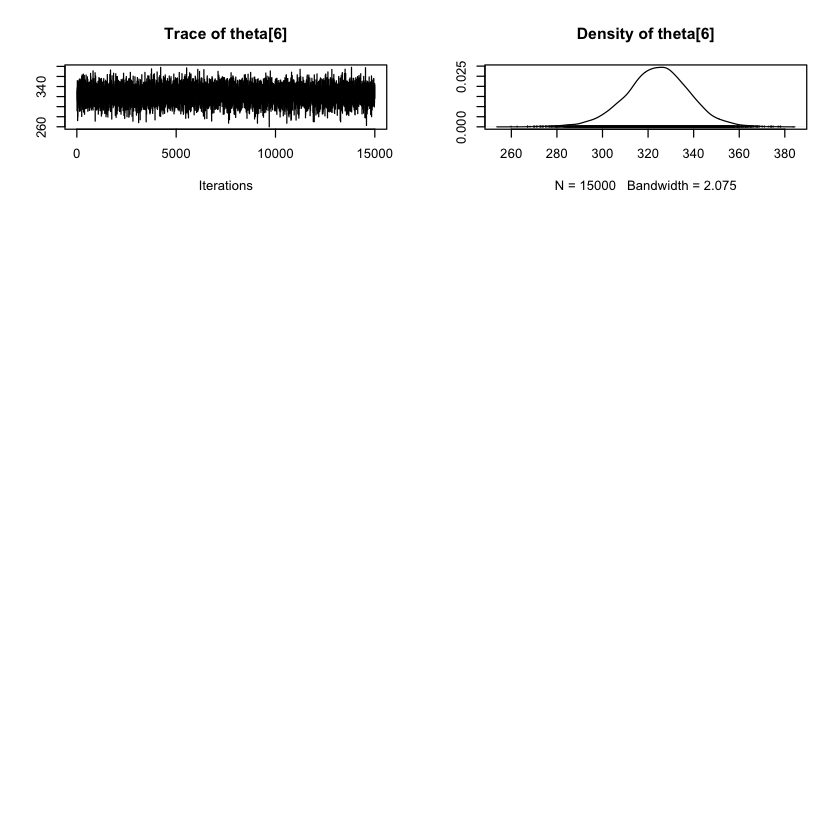

In [54]:
plot(mod.hier.var.het$csim, ask=FALSE)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



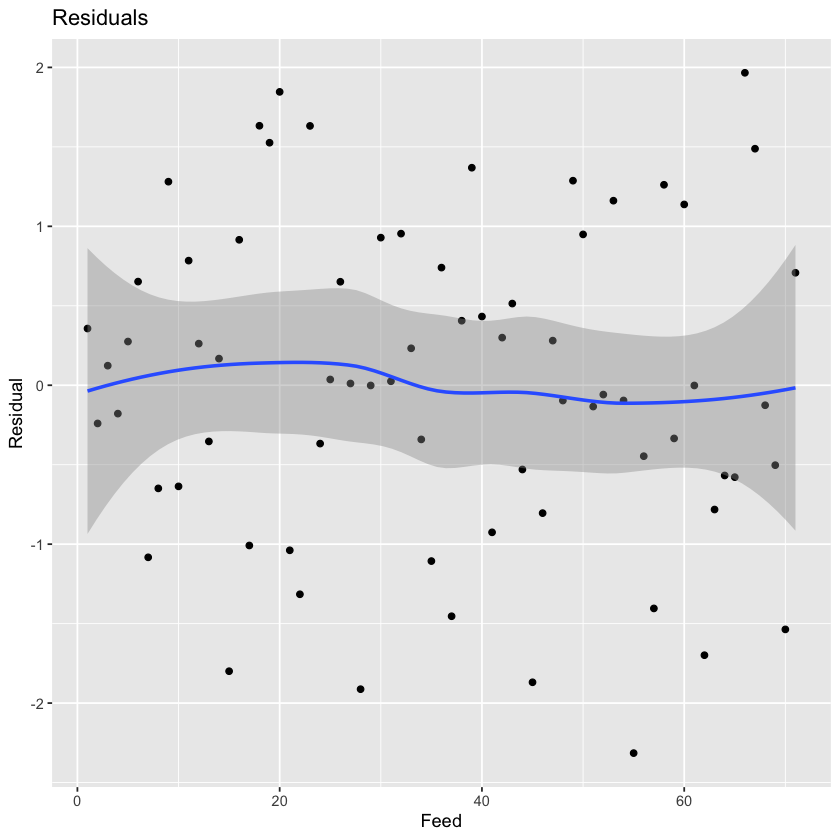

In [55]:
res = data$weight - mod.hier.var.het$coefs[8:13][data$feed]
gg_resid(res, normalize=TRUE)

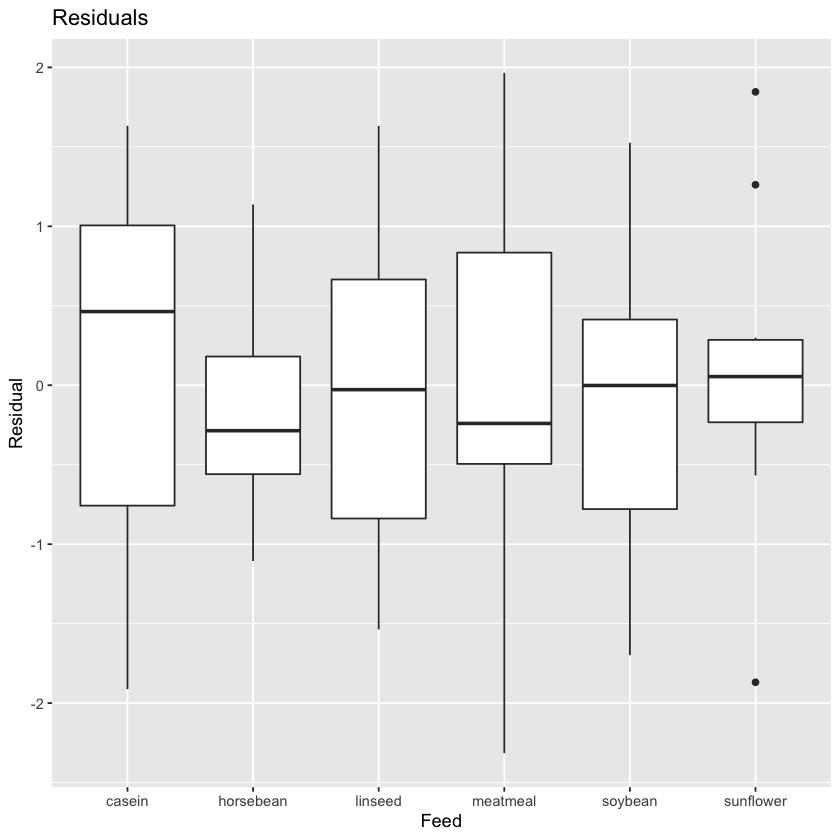

In [56]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

## Heterogenous Model

$$ Weight_{ij} \sim Normal(\theta_j, \sigma) $$

$$ \theta_j \sim Normal(\mu_j, \tau_j) $$

In [57]:
mod_string = " model {
  for (i in 1:length(weight)) {
    weight[i] ~ dnorm(theta[feed[i]], prec.sigma)
  }
  
  for (j in 1:max(feed)) {
    theta[j] ~ dnorm(mu[j], prec.tau[j])
    mu[j] ~ dnorm(0, 1.0/1.0e6)
    prec.tau[j] ~ dexp(1)
    tau[j] = sqrt(1/prec.tau[j])
  }
  
  prec.sigma ~ dexp(1)
  sigma = sqrt(1/prec.sigma)
  
} "

set.seed(43)
data_jags = as.list(data)
params = c("theta", "tau")

mod.het = run_sim(
    model.str = mod_string,
    data = data_jags,
    params = params,
    burn_in=5e3,
    n_iter=5e4
)

Warning message in jags.model(file = textConnection(model.str), data = data, n.chains = n_chains):
“Unused variable "feed_name" in data”


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 71
   Unobserved stochastic nodes: 19
   Total graph size: 179

Initializing model



#### Results

In [58]:
summary(mod.het$sim)


Iterations = 5001:55000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean     SD Naive SE Time-series SE
tau[1]     1.764  3.087 0.007971        0.01522
tau[2]     1.756  3.177 0.008203        0.01305
tau[3]     1.762  2.890 0.007461        0.01418
tau[4]     1.747  2.296 0.005929        0.01045
tau[5]     1.759  2.950 0.007618        0.01271
tau[6]     1.748  2.411 0.006225        0.01088
theta[1] 323.446 15.564 0.040187        0.42918
theta[2] 159.379 17.025 0.043959        0.49208
theta[3] 218.645 15.879 0.041000        0.44451
theta[4] 276.536 16.577 0.042801        0.47136
theta[5] 246.723 14.885 0.038434        0.39143
theta[6] 328.218 16.067 0.041485        0.44705

2. Quantiles for each variable:

             2.5%      25%     50%     75%   97.5%
tau[1]     0.5179   0.8472   1.198   1.869   6.304
tau[2]     0.5209   0.8497   1.203   1.86

In [59]:
round(mod.het$coefs, 4)

tau[1]   tau[2]   tau[3]   tau[4]   tau[5]   tau[6] theta[1] theta[2] 
  1.7644   1.7557   1.7624   1.7470   1.7589   1.7477 323.4463 159.3786 
theta[3] theta[4] theta[5] theta[6] 
218.6452 276.5362 246.7235 328.2184

In [60]:
(dic.het = dic.samples(mod.het$obj, n.iter=1e3))

Mean deviance:  772.2 
penalty 8.538 
Penalized deviance: 780.7 

#### Convergence

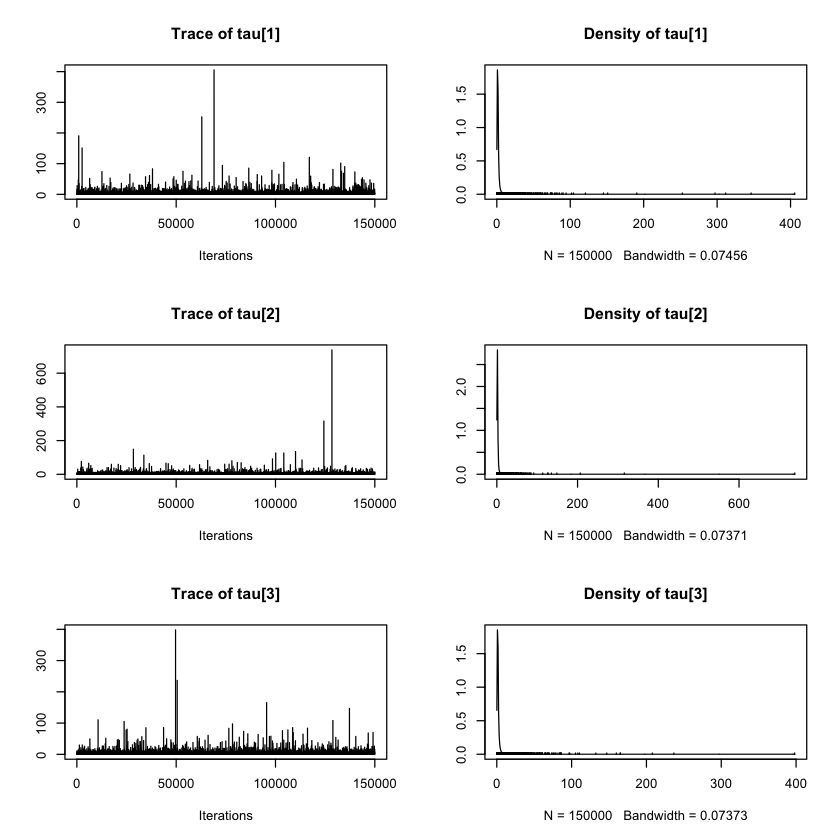

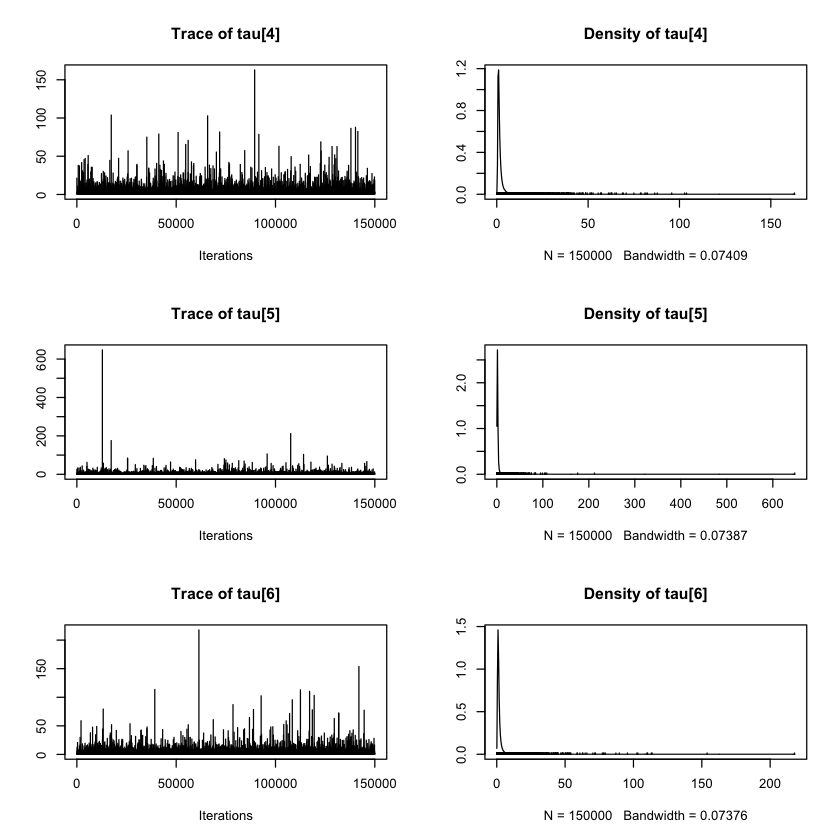

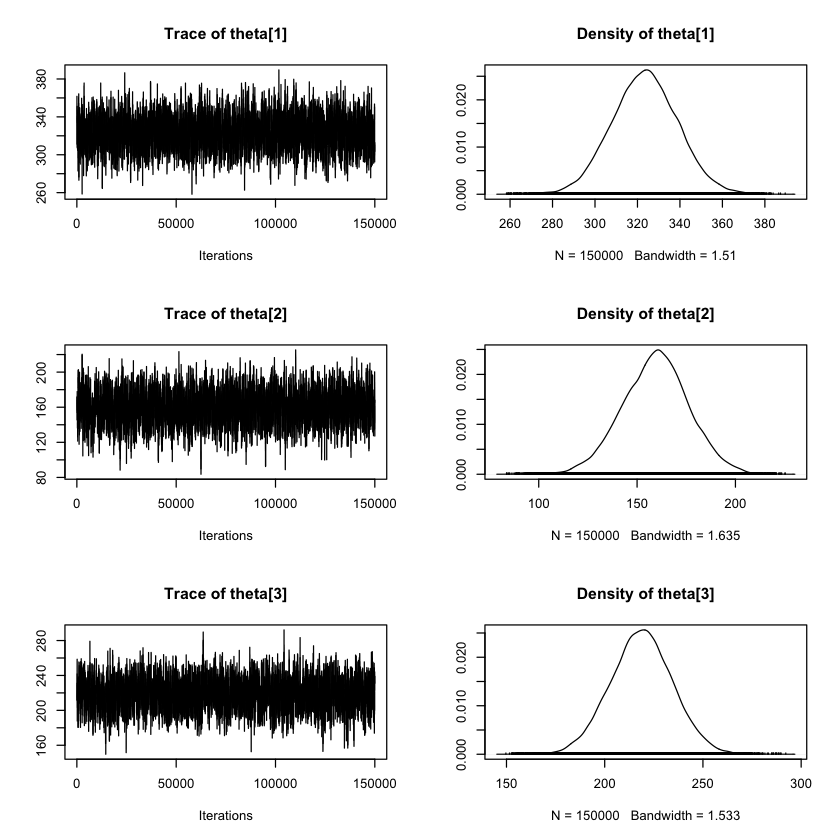

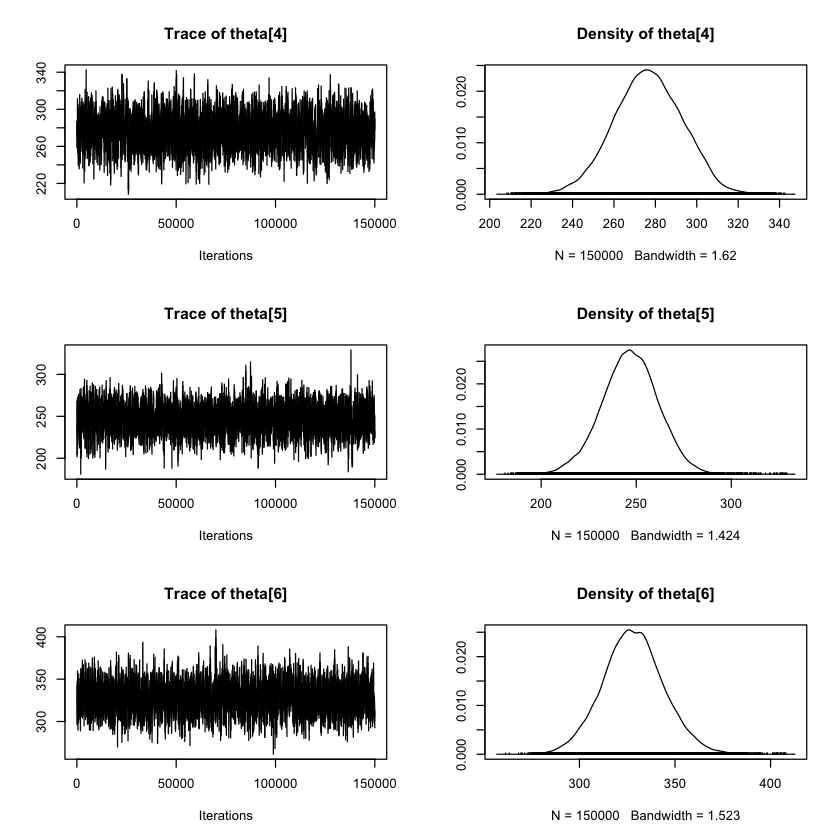

In [61]:
plot(mod.het$csim, ask=FALSE)

#### Residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



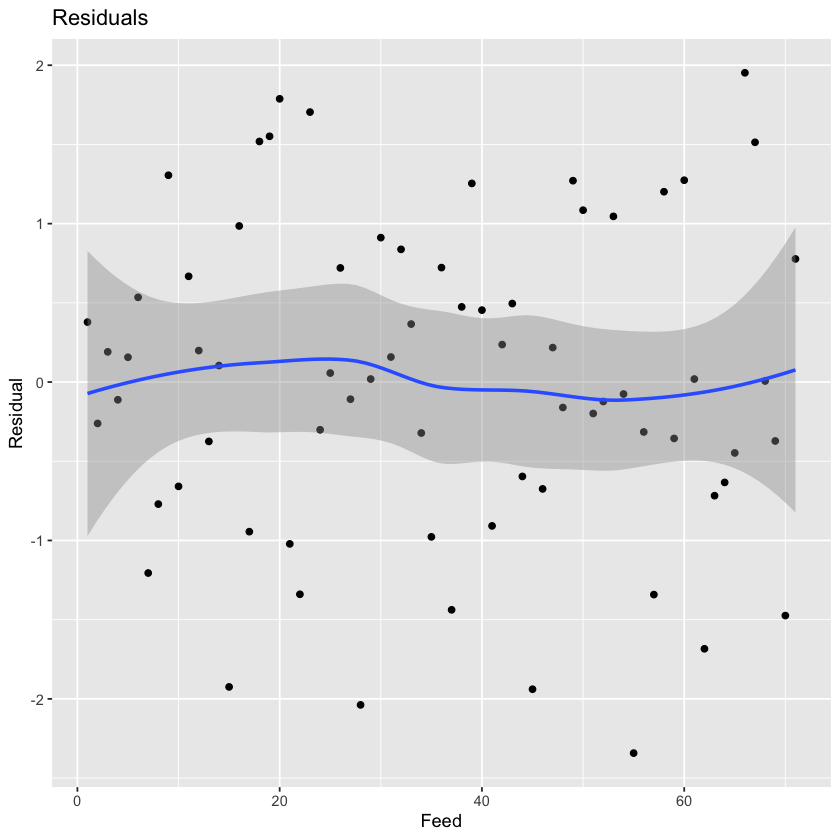

In [63]:
res = data$weight - mod.het$coefs[7:12][data$feed]
gg_resid(res, normalize=TRUE)

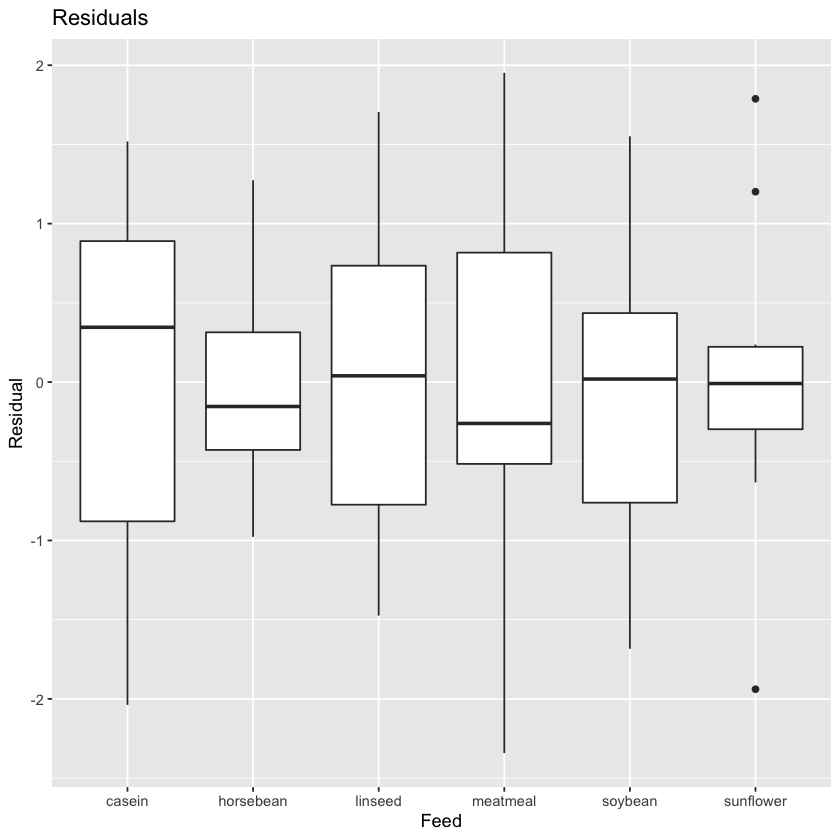

In [64]:
gg_resid.cat(data$feed_name, res, normalize=TRUE)

## Posterior Analysis

[1] 91.97441

[1] 550.8563

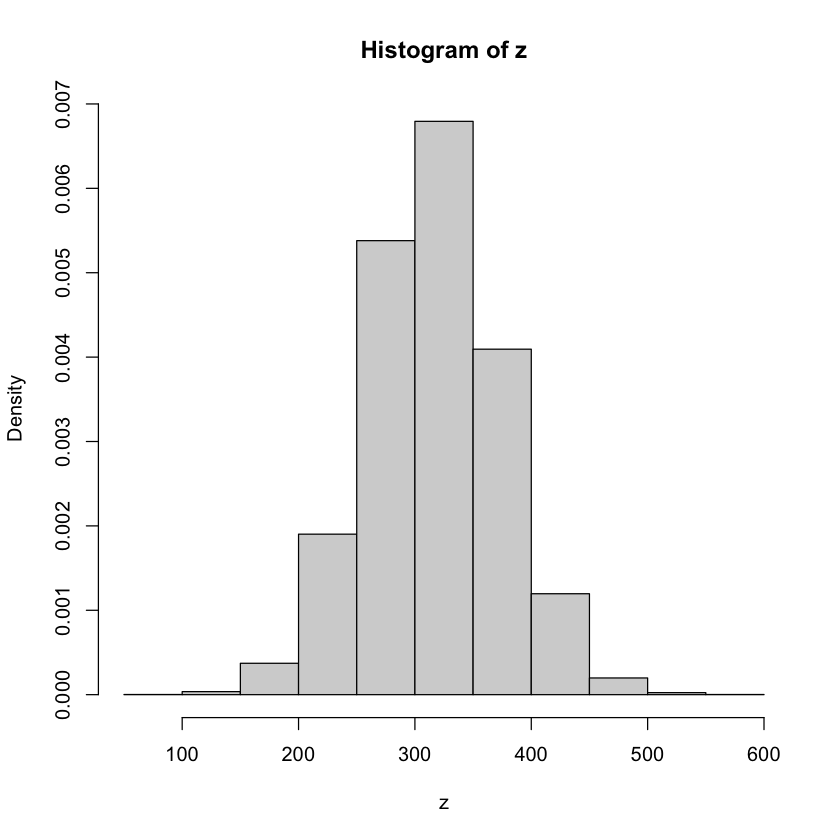

In [65]:
N = 1e4

theta1.post = sample(mod.hier$csim[, 3], N, replace = TRUE)
sigma.post = sample(mod.hier$csim[, 2], N, replace = TRUE)
z = rnorm(N, mean=theta1.post, sd=sigma.post)
hist(z, freq = FALSE)
min(z)
max(z)

In [66]:
mean(mod.hier$csim[, "theta[6]"] > mod.hier$csim[, "theta[1]"])

[1] 0.5977333

In [67]:
set.seed(43)
N = 1e4

theta.mat = matrix(, nrow = N, ncol = 6)
sigma.mat = matrix(, nrow = N, ncol = 6)
z = matrix(, nrow = N, ncol = 6)

for (i in 3:8) {
    theta.sample = sample(mod.hier$csim[, i], N, replace = TRUE)
    sigma.sample = sample(mod.hier$csim[, 2], N, replace = TRUE)
    z[, i-2] = rnorm(N, mean=theta.sample, sd=sigma.sample)

}

In [68]:
mean(z[, 1] > z[, 6])

[1] 0.4707

In [69]:
for (i in 2:6) {
    print(mean(z[, 1] > z[, i]))
    }

[1] 0.9652
[1] 0.8823
[1] 0.691
[1] 0.8056
[1] 0.4707


In [70]:
for (i in 1:5) {
    print(mean(z[, 6] > z[, i]))
    }

[1] 0.5293
[1] 0.9726
[1] 0.895
[1] 0.7153
[1] 0.8257
